In [1]:
from common import *
from process_ntuples import *
from process_df import *
from plotting import *
from cuts import apply_cuts, apply_pt_cut
import matplotlib.pyplot as plt
import pickle
import time

import tensorflow as tf
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

from tensorflow.keras.callbacks import EarlyStopping

#weights and biases imports
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback

Welcome to JupyROOT 6.28/00


2023-04-26 22:44:18.570977: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 22:44:19.940795: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


$D^{+}$ : 411

$\Lambda_C^{+}$ : 4122

Apply Cuts Fiducial Region cuts ($𝐷^{+}$ $𝑝_T$ > 8 GeV, |𝜂| < 2.2). ***See cuts.py on how the cuts are applied***

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[]
Num GPUs Available:  0


2023-04-26 20:14:27.175627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [218]:
dir_path = "/global/cfs/cdirs/atlas/gottino/Charm/Analysis/run_batch_gup/ntuples"

files = os.listdir(dir_path)

DMesonsTTree = process_ntuple(dir_path, files[0])
LambdaMesonsTTree = process_ntuple(dir_path, files[1])

branches = ["DMesons_pt", "DMesons_eta", "DMesons_m", "DMesons_fitOutput__Lxy", "DMesons_costhetastar", "DMesons_pdgId", 
            "DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId",
           "DMesons_fitOutput__ImpactSignificance"]

print(files)

['CharmAnalysis.mc.ForcedDecay.Dplus.tree.root', 'CharmAnalysis.mc.ForcedDecay.LabmdaC.tree.root']


In [8]:
DMesons_df = generate_df(DMesonsTTree, branches, 2000000)
DMesons_df = apply_cuts(DMesons_df)

pd.set_option('display.max_rows', 10)
DMesons_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance
0,[10.047125],[0.08182407170534134],[1862.4176025390625],[2.3395302295684814],[0.25487038493156433],[411],"[[6.094892978668213, 1.3074619770050049, 2.733...","[(0.15998553, 0.011107716, -0.0614343)]","[(2.6128821, 2.7195172, 2.9228168)]","[(-321, 211, 211)]",[0.5543845891952515]
1,"[18.9937421875, 18.9937421875]","[-1.6619627475738525, -1.6619627475738525]","[1853.90625, 2398.886962890625]","[1.9184143543243408, 1.9184143543243408]","[-0.36730244755744934, -0.0650731548666954]","[411, 4122]","[[6.457057952880859, 5.970093250274658, 6.6375...","[(-1.608788, -1.6307458, -1.7315177), (-1.7326...","[(-0.371787, -0.5164238, -0.4971406), (-0.4966...","[(-321, 211, 211), (2212, -321, 211)]","[1.8095015287399292, 1.8095015287399292]"
2,"[10.118494140625, 10.118494140625]","[0.041659336537122726, 0.041659336537122726]","[1874.203125, 2468.1806640625]","[2.8901257514953613, 2.8901257514953613]","[0.06833142042160034, 0.4276972711086273]","[411, 4122]","[[3.7944977283477783, 3.3083105087280273, 3.06...","[(-0.073717244, 0.22605924, -0.017923404), (0....","[(0.753864, 0.6827104, 0.920779), (0.6827104, ...","[(-321, 211, 211), (2212, -321, 211)]","[2.292919158935547, 2.292919158935547]"
3,"[12.579470703125, 12.579470703125]","[-1.1025604009628296, -1.1025604009628296]","[1884.987060546875, 2220.384521484375]","[0.9249186515808105, 0.9249186515808105]","[-0.5603189468383789, -0.41332852840423584]","[411, 4122]","[[3.7815563678741455, 7.396467208862305, 1.412...","[(-0.9284433, -1.182188, -1.1012387), (-1.1821...","[(0.8518817, 0.7419038, 0.77916163), (0.741903...","[(-321, 211, 211), (2212, -321, 211)]","[0.7992758750915527, 0.7992758750915527]"
4,[36.1288359375],[0.6598162055015564],[2235.69873046875],[0.3584118187427521],[0.19036155939102173],[4122],"[[18.936317443847656, 15.39889907836914, 1.803...","[(0.69086045, 0.62282157, 0.63955635)]","[(0.857847, 0.81737196, 0.7582323)]","[(2212, -321, 211)]",[1.1388494968414307]
...,...,...,...,...,...,...,...,...,...,...,...
823353,[19.1050703125],[1.6708742380142212],[1802.5220947265625],[0.5411524176597595],[0.5503742098808289],[411],"[[12.198583602905273, 2.20495867729187, 4.7119...","[(1.705293, 1.5110217, 1.6457342)]","[(2.8939261, 2.7120652, 2.8616462)]","[(-321, 211, 211)]",[2.8667211532592773]
823354,"[35.5684921875, 35.5684921875]","[-1.688397765159607, -1.688397765159607]","[1844.779541015625, 2206.408203125]","[13.070379257202148, 13.070379257202148]","[-0.9140324592590332, -0.8278874754905701]","[411, 4122]","[[5.796909809112549, 20.56328582763672, 9.2475...","[(-1.6683935, -1.7061399, -1.6597538), (-1.706...","[(1.4682562, 1.4755678, 1.4053382), (1.4755678...","[(-321, 211, 211), (2212, -321, 211)]","[3.2546143531799316, 3.2546143531799316]"
823355,"[8.96414453125, 8.96414453125]","[-2.151238203048706, -2.151238203048706]","[1906.624267578125, 2233.773193359375]","[1.6992524862289429, 1.6992524862289429]","[0.1967991143465042, 0.495256245136261]","[411, 4122]","[[3.0222578048706055, 5.220008850097656, 0.736...","[(-2.0755956, -2.2418754, -1.6611706), (-2.241...","[(1.9180546, 1.8532572, 2.0587387), (1.8532572...","[(-321, 211, 211), (2212, -321, 211)]","[0.9604215025901794, 0.9604215025901794]"
823356,[17.66424609375],[-0.09207434207201004],[1886.3043212890625],[1.2944053411483765],[0.28153401613235474],[411],"[[9.11902904510498, 5.195584774017334, 3.37626...","[(-0.045325126, -0.065605104, -0.25413564)]","[(1.7839004, 1.9068127, 1.8262501)]","[(-321, 211, 211)]",[3.164067029953003]


In [220]:
Lambda_df = generate_df(LambdaMesonsTTree, branches, 2000000)
Lambda_df = apply_cuts(Lambda_df)

pd.set_option('display.max_rows', 10)
Lambda_df

In [ ]:
#DMesons_df = remove_duplicates(DMesons_df)
Lambda_df = remove_duplicates(Lambda_df)

Removed 0 duplicate particles


In [11]:
save(DMesons_df, "DMesons_df")
save(Lambda_df, "Lambda_df")

In [221]:
DMesons_df = load("DMesons_df")
Lambda_df = load("Lambda_df")

In [222]:
DMesons_df = DMesons_df.head(500000)
Lambda_df = Lambda_df.head(500000)

In [223]:
#separates each particle of the event into it's own event in a new data frame (for training)
def separate(df):
    dfs = []
    for index, row in df.iterrows():

        #reco Ds
        pts = row['DMesons_pt']
        etas = row['DMesons_eta']
        ms = row['DMesons_m']
        lxys = row['DMesons_fitOutput__Lxy']
        costhetastars = row['DMesons_costhetastar']
        impacts = row['DMesons_fitOutput__ImpactSignificance']
        pdgids = row["DMesons_pdgId"]

        #reco Ds Daughter info
        daughter_pts = row["DMesons_daughterInfo__pt"]
        daughter_etas = row["DMesons_daughterInfo__eta"]
        daughter_phis = row["DMesons_daughterInfo__phi"]
        daughter_pdgIds = row["DMesons_daughterInfo__pdgId"]

        d = {df.columns[0]: pts, df.columns[1]: etas, df.columns[2]: ms, df.columns[3]: lxys, 
             df.columns[4]: costhetastars, df.columns[5]: pdgids, 

             df.columns[6]: daughter_pts, df.columns[7]: daughter_etas, df.columns[8]: daughter_phis, 
             df.columns[9]: daughter_pdgIds, 
             
             df.columns[10]: impacts}
        
        df = pd.DataFrame(data=d)

        dfs.append(df)

    df = pd.concat(dfs)
    df = df.reset_index(drop = True)
    return df

In [ ]:
#DMesons_df = separate(DMesons_df)
Lambda_df = separate(Lambda_df)

In [4]:
# save(DMesons_df, "DMesons_df_separated")
# save(Lambda_df, "Lambda_df_separated")

# DMesons_df = load("DMesons_df_separated")
# Lambda_df = load("Lambda_df_separated")

In [59]:
DPlus = [-321, 211, 211]
LambdaC = [2212, -321, 211]

remove_lambda = []

count = 0
for index, row in DMesons_df.iterrows():
    if count == 50:
        break
    count+=1
    
    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    pdgids = row["DMesons_daughterInfo__pdgId"]
    
    #loop through until the first lambda encountered
    for i in range(len(pdgids) - 1):
        #if there are multiple lambda baryons
        if len(pdgids) > 2:
            #stop at the first lambda and keep the higher proton pt valued lambda
            if list(pdgids[i]) == LambdaC:
                l1_pt, l2_pt = pts[i][0], pts[i + 1][0]
                if (l1_pt > l2_pt):
                    #Lambda 1's proton has higher pt
                    remove_lambda.append((index, i + 1))
                elif (l1_pt < l2_pt):
                    #Lambda 2's proton has higher pt!
                    remove_lambda.append((index, i))
                else:
                    raise Exception("Error: Are the proton pt vaules equal?")

len(remove_lambda)

3

In [24]:
#takes tuples of shape (2,) / (index, column)
def remove_particles_from_df(df, tuple_list):
    for tup in tuple_list:
        index, column = tup
        print(index, column)
        
        new_df = df.copy()
        for i in range(len(DMesons_df.iloc[index, 0][column]) + 1):
            #new_df["DMesons_daughterInfo__pt"] = new_df["DMesons_daughterInfo__pt"].apply(lambda x: print(x))
            val = new_df.iloc[index, i][column]
            print(val)
    df = df.drop(index, axis = 0)
    return df
#df = remove_particles_from_df(DMesons_df, remove_lambda)

pd.set_option('display.max_rows', 10)

In [11]:
def count(df):
    D = 0
    Lambda = 0
    for pdgId in df["DMesons_pdgId"]:
        if pdgId == 411 or pdgId == 0:
            D+=1
        elif pdgId == 4122 or pdgId == 1:
            Lambda+=1
    return D, Lambda

count(DMesons_df)

(6280052, 6017574)

In [55]:
def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

DMesons_df['particle_type'] = DMesons_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = DMesons_df[DMesons_df['particle_type'] == 'only_411']
only_4122 = DMesons_df[DMesons_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

#new_df = DMesons_df[DMesons_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [56]:
save(only_4122, "DMesons_only_4122")

In [ ]:
# create a new column 'particle_type' based on the pdgId column

def func(x):
    if x == 411:
        return 'only_411'
    elif x == 4122:
        return 'only_4122'
    # else:
    #     return "both"

Lambda_df['particle_type'] = Lambda_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = Lambda_df[Lambda_df['particle_type'] == 'only_411']
only_4122 = Lambda_df[Lambda_df['particle_type'] == 'only_4122']
#both = DMesons_df[DMesons_df['particle_type'] == 'both']

# new_df = Lambda_df[Lambda_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [ ]:
save(only_4122, "Lambda_only_4122")

In [131]:
# Read
Lambda_only_4122 = load("Lambda_only_4122")
DMesons_only_4122 = load("Sherpa_DMesons_only_4122")

In [234]:
len(DMesons_only_4122)

690863

In [235]:
DMesons_only_4122['DMesons_pdgId'] = DMesons_only_4122['DMesons_pdgId'].replace({4122: 411})

DMesons_only_4122

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,DMesons_fitOutput__ImpactSignificance,particle_type
27,124.551781,0.616144,2252.343994,1.000073,0.309355,411,"[45.35352325439453, 55.5874137878418, 23.73572...","(0.62828386, 0.6060324, 0.61673385)","(3.135228, 3.1389863, -3.1324918)","(2212, -321, 211)",1.687575,only_4122
28,52.491680,0.628072,2420.752197,9.001939,-0.999371,411,"[45.325809478759766, 3.1020970344543457, 3.886...","(0.6306876, 0.61715966, 0.6021761)","(3.1351142, 3.1380522, -3.100118)","(2212, -321, 211)",4.709635,only_4122
29,51.824703,0.628606,2289.998535,0.752138,-0.955626,411,"[45.20779800415039, 5.494213104248047, 1.12326...","(0.6285973, 0.60806257, 0.7257996)","(3.135263, 3.1376371, 3.0532124)","(2212, -321, 211)",0.082626,only_4122
30,74.569516,0.623304,2320.748779,0.825154,-0.988731,411,"[45.4151725769043, 5.492096424102783, 23.73572...","(0.6285476, 0.6079869, 0.61673385)","(3.1352143, 3.1375391, -3.1324918)","(2212, -321, 211)",0.285478,only_4122
31,52.139363,0.628442,2114.455566,14.295114,-0.967880,411,"[45.4952392578125, 5.527915000915527, 1.113548...","(0.6305013, 0.60626864, 0.66872984)","(3.1350088, 3.1403995, -3.1118574)","(2212, -321, 211)",4.459208,only_4122
...,...,...,...,...,...,...,...,...,...,...,...,...
769898,15.015752,-1.621316,2128.959717,1.055468,-0.955383,411,"[10.978409767150879, 1.5513936281204224, 2.492...","(-1.6365633, -1.4952528, -1.6247052)","(-0.16868365, -0.11923864, -0.22785482)","(-2212, 321, -211)",4.102871,only_4122
769899,13.776949,-1.625336,2419.603516,0.624960,-0.933207,411,"[11.055854797363281, 1.5394558906555176, 1.245...","(-1.6374356, -1.5005118, -1.6150558)","(-0.1682525, -0.11801015, 0.16930138)","(-2212, 321, -211)",1.601410,only_4122
769900,16.353774,-1.603238,2288.062256,3.461010,-0.961579,411,"[11.229562759399414, 1.516668438911438, 3.6428...","(-1.6382093, -1.4983779, -1.5304362)","(-0.16720171, -0.11406519, -0.21755505)","(-2212, 321, -211)",2.295237,only_4122
769901,14.328731,-1.612592,2169.589355,1.799214,-0.948991,411,"[11.196073532104492, 1.5245026350021362, 1.622...","(-1.6378483, -1.4999491, -1.5262128)","(-0.16747509, -0.1153605, -0.27906275)","(-2212, 321, -211)",2.297870,only_4122


In [132]:
Lambda_only_4122 = Lambda_only_4122.head(500000)
DMesons_only_4122 = DMesons_only_4122.head(500000)
DMesons_only_4122 = DMesons_only_4122.reset_index(drop=True)

combined_df = pd.concat([Lambda_only_4122, DMesons_only_4122], axis=0)

# Shuffle the rows of the combined data frame
shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)

Text(0.5, 0, 'Mass (MeV)')

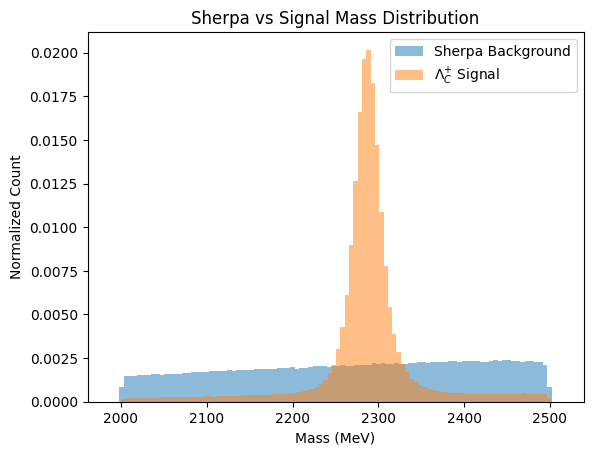

In [134]:
counts, bins, _ = plt.hist(DMesons_only_4122["DMesons_m"], bins=100)
counts2, bins2, _ = plt.hist(Lambda_only_4122["DMesons_m"], bins=100)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

    # Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs Signal Mass Distribution")
plt.legend()
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")

In [238]:
shuffled_df['DMesons_daughterInfo__pdgId'] = [(2212, -321, 211)] * len(shuffled_df)

In [239]:
shuffled_df["DMesons_daughterInfo__eta"] = shuffled_df["DMesons_daughterInfo__eta"].apply(list)
shuffled_df["DMesons_daughterInfo__phi"] = shuffled_df["DMesons_daughterInfo__phi"].apply(list)

In [ ]:
#shuffled_df_daughter = shuffled_df[["DMesons_daughterInfo__pt", "DMesons_daughterInfo__eta", "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"]]

In [240]:
#separate the daughter info
daughter_pts = []
daughter_etas = []
daughter_phis = []

for index, row in shuffled_df.iterrows():

    pts = row['DMesons_daughterInfo__pt']
    etas = row['DMesons_daughterInfo__eta']
    phis = row['DMesons_daughterInfo__phi']
    
    for pt, eta, phi in zip(pts, etas, phis):
        daughter_pts.append(pt)
        daughter_etas.append(eta)
        daughter_phis.append(phi)

In [241]:
#particle1 is proton, or pion in D+ hyp
#particle2 is kaon
#particle3 is pion

particle1_pt = []
particle2_pt = []
particle3_pt = []

particle1_eta = []
particle2_eta = []
particle3_eta = []

particle1_phi = []
particle2_phi = []
particle3_phi = []

for i in range(0, len(daughter_pts), 3):
    #daughter_pt
    particle1_pt.append(daughter_pts[i])
    particle2_pt.append(daughter_pts[i+1])
    particle3_pt.append(daughter_pts[i+2])
    
    #daughter_eta
    particle1_eta.append(daughter_etas[i])
    particle2_eta.append(daughter_etas[i+1])
    particle3_eta.append(daughter_etas[i+2])
    
    #daughter_phi
    particle1_phi.append(daughter_phis[i])
    particle2_phi.append(daughter_phis[i+1])
    particle3_phi.append(daughter_phis[i+2])

In [ ]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass3 pipi (assuming p is pi)

#pions
#inv_mass4 is pion pion (first pion was proton) (second pion was kaon)
#inv_mass5 is pion pion (first pion was kaon) (second is still pion)
#inv_mass6 is pion pion (first pion was proton) (second is still pion)

#Lambda Hypothesis
#inv_mass7 is pk assuming proton is proton
#inv_mass8 is kpi
#inv_mass9 ppi

In [ ]:
k_mass = 0.493677 #Gev/c^2
pi_mass = 0.13957 #Gev/c^2
p_mass = 0.938 #Gev/c^2

def createTLorentzVectors(df):
    TLorentzVectorList = []
    
    for index, row in df.iterrows():
        pts = row['DMesons_daughterInfo__pt']
        etas = row['DMesons_daughterInfo__eta']
        phis = row['DMesons_daughterInfo__phi']
        pdgids = row['DMesons_daughterInfo__pdgId']
        types = row["particle_type"]
        
        def assign_mass():
            if types == "only_411" or "only_4122":
                #D+ Hypothesis: assume proton is pion for 
                #Lambda Hypothesis: keep proton as proton
                return p_mass
            else:
                raise Exception("Are there more particle types?")
            
        for pt, eta, phi, pdgid in zip(pts, etas, phis, pdgids):
            if pdgid == 211:
                m = pi_mass
            elif pdgid == -321:
                m = k_mass
            elif pdgid == 2212:
                m = assign_mass()
            else:
                continue

            p = ROOT.TLorentzVector()
            p.SetPtEtaPhiM(pt, eta, phi, m)
            TLorentzVectorList.append(p)

    return TLorentzVectorList

inv_mass_squared = lambda p1, p2: (p1 + p2).M2()

In [259]:
LorentzVectors = createTLorentzVectors(shuffled_df)
reshaped_list = [LorentzVectors[i:i+3] for i in range(0, len(LorentzVectors), 3)]
np.shape(reshaped_list)

(1000000, 3)

In [262]:
pk_list = []
kpi_list = []
ppi_list = []

#find the ordering of the Loretnz Vectors

#Lambda Hypothesis
p_LorentzVectors = []
k_LorentzVectors = []
pi_LorentzVectors = []
for i in LorentzVectors:
    if round(i.M(), 3) == p_mass:
        p_LorentzVectors.append(i)
    elif round(i.M(), 6) == k_mass:
        k_LorentzVectors.append(i)
    elif round(i.M(), 4) == 0.1396:
        pi_LorentzVectors.append(i)

#D+ Hypothesis
# p_LorentzVectors = []
# k_LorentzVectors = []
# pi_LorentzVectors = []
# for sublist in reshaped_list:
#     for i in range(len(sublist)):
#         if round(sublist[i].M(), 4) == 0.1396 and i == 0:
#             p_LorentzVectors.append(sublist[0])
#         elif round(sublist[i].M(), 4) == 0.4937 and i == 1:
#             k_LorentzVectors.append(sublist[1])
#         elif round(sublist[i].M(), 4) == 0.1396 and i == 2:
#             pi_LorentzVectors.append(sublist[2])

In [263]:
for i in range(len(p_LorentzVectors)):
    pk = inv_mass_squared(p_LorentzVectors[i], k_LorentzVectors[i])
    kpi = inv_mass_squared(k_LorentzVectors[i], pi_LorentzVectors[i])
    ppi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
    pk_list.append(pk)
    kpi_list.append(kpi)
    ppi_list.append(ppi)

In [197]:
#Lambda
# for i in range(len(p_LorentzVectors)):
#     ppi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
#     ppi_list.append(ppi)

In [190]:
#D
# for i in range(len(p_LorentzVectors)):
#     pipi = inv_mass_squared(p_LorentzVectors[i], pi_LorentzVectors[i])
#     pipi_list.append(pipi)

In [264]:
#D+ hypothesis
#inv_mass1 is pk assuming proton is pion for all candidates
#inv_mass2 is kpi
#inv_mass3 pipi (assuming p is pi)

#pions
#inv_mass4 is pion pion (first pion was proton) (second pion was kaon)
#inv_mass5 is pion pion (first pion was kaon) (second is still pion)
#inv_mass6 is pion pion (first pion was proton) (second is still pion)

#Lambda Hypothesis
#inv_mass7 is pk assuming proton is proton
#inv_mass8 is kpi
#inv_mass9 ppi

shuffled_df['inv_mass7'] = pk_list
shuffled_df['inv_mass8'] = kpi_list
shuffled_df['inv_mass9'] = ppi_list

In [265]:
shuffled_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_daughterInfo__pt,DMesons_daughterInfo__eta,DMesons_daughterInfo__phi,DMesons_daughterInfo__pdgId,...,particle_type,inv_mass1,inv_mass2,inv_mass3,inv_mass4,inv_mass5,inv_mass6,inv_mass7,inv_mass8,inv_mass9
0,14.551307,-0.503012,2211.277832,0.105686,-0.462903,411,"[11.170928001403809, 2.831317901611328, 0.6029...","[-0.4977727, -0.55253094, -0.31940895]","[0.45178226, 0.5159005, 0.88359225]","(2212, -321, 211)",...,only_4122,1.424463,0.732076,1.873404,0.343701,0.463657,1.873404,2.510926,0.732076,2.778089
1,10.616373,-1.239521,2226.512207,0.547223,0.957469,411,"[3.040483236312866, 6.920453071594238, 0.66697...","[-1.2389119, -1.2671988, -0.891992]","[2.288972, 2.2705233, 2.100124]","(2212, -321, 211)",...,only_4122,0.437135,1.342377,0.476848,0.116725,1.101903,0.476848,3.291010,1.342377,1.481510
2,8.041471,0.740541,2292.695068,0.648762,-0.224572,4122,"[4.130668640136719, 2.183924913406372, 1.80589...","[0.61786264, 0.9393891, 0.7249763]","[-2.7951388, -3.0525513, -2.6634498]","(2212, -321, 211)",...,only_4122,2.183149,1.235540,0.304696,1.616657,0.851758,0.304696,3.605317,1.235540,1.562662
3,14.505914,1.700047,2277.017822,0.415693,0.281155,4122,"[5.195446968078613, 7.804042816162109, 1.53329...","[1.7886169, 1.6211084, 1.7547115]","[-0.67071944, -0.5331284, -0.63166416]","(2212, -321, 211)",...,only_4122,2.384678,0.734953,0.133974,1.985845,0.460789,0.133974,4.349245,0.734953,1.240154
4,9.190323,0.948899,2467.892822,0.088807,-0.964863,411,"[5.592108726501465, 0.7378090620040894, 2.8988...","[1.0165381, 0.6699291, 0.87115043]","[0.7204874, 0.5911911, 0.61206007]","(2212, -321, 211)",...,only_4122,3.025494,1.376170,0.623499,0.796600,0.217839,0.623499,3.987457,1.376170,1.883637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,32.272094,-0.041371,2258.133057,0.269147,-0.166023,4122,"[19.53499984741211, 10.94820785522461, 1.82099...","[-0.059171885, -0.013583427, -0.018911816]","[-2.877898, -2.9645057, -2.8272035]","(2212, -321, 211)",...,only_4122,2.757283,0.796590,0.398840,2.132483,0.534964,0.398840,4.099238,0.796590,1.339467
999996,49.044613,-1.551618,2302.039551,0.211826,0.901419,411,"[10.073150634765625, 30.05179214477539, 8.9344...","[-1.5475895, -1.54694, -1.5712011]","[1.316317, 1.3007066, 1.3279157]","(2212, -321, 211)",...,only_4122,0.476911,0.758174,0.140392,0.177466,0.465773,0.140392,3.901641,0.758174,1.780263
999997,15.512543,-0.002953,2162.263672,0.298673,-0.881231,411,"[12.885456085205078, 2.0564074516296387, 0.600...","[0.013616143, -0.08536845, -0.07438314]","[0.5507237, 0.59127384, 0.8937046]","(2212, -321, 211)",...,only_4122,2.070365,0.513330,1.412748,0.466976,0.222930,1.412748,3.072219,0.513330,2.314334
999998,9.649199,0.248185,2028.827759,0.154665,0.676143,411,"[3.514936923980713, 5.062290668487549, 1.09335...","[0.21267407, 0.22728372, 0.44851756]","[-1.1488833, -1.3185775, -1.2333149]","(2212, -321, 211)",...,only_4122,0.974722,0.715890,0.345574,0.595541,0.439397,0.345574,3.062715,0.715890,1.491429


In [266]:
invmass_ready_df = shuffled_df.drop(['DMesons_daughterInfo__pt', 'DMesons_daughterInfo__eta', "DMesons_daughterInfo__phi", "DMesons_daughterInfo__pdgId", "particle_type"], axis=1)
invmass_ready_df["daughter_pt1"] = particle1_pt
invmass_ready_df["daughter_pt2"] = particle2_pt
invmass_ready_df["daughter_pt3"] = particle3_pt
invmass_ready_df["daughter_eta1"] = particle1_eta
invmass_ready_df["daughter_eta2"] = particle2_eta
invmass_ready_df["daughter_eta3"] = particle3_eta
invmass_ready_df["daughter_phi1"] = particle1_phi
invmass_ready_df["daughter_phi2"] = particle2_phi
invmass_ready_df["daughter_phi3"] = particle3_phi
invmass_ready_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,14.551307,-0.503012,2211.277832,0.105686,-0.462903,411,1.598548,1.424463,0.732076,1.873404,...,2.778089,11.170928,2.831318,0.602950,-0.497773,-0.552531,-0.319409,0.451782,0.515900,0.883592
1,10.616373,-1.239521,2226.512207,0.547223,0.957469,411,2.001802,0.437135,1.342377,0.476848,...,1.481510,3.040483,6.920453,0.666974,-1.238912,-1.267199,-0.891992,2.288972,2.270523,2.100124
2,8.041471,0.740541,2292.695068,0.648762,-0.224572,4122,0.782303,2.183149,1.235540,0.304696,...,1.562662,4.130669,2.183925,1.805893,0.617863,0.939389,0.724976,-2.795139,-3.052551,-2.663450
3,14.505914,1.700047,2277.017822,0.415693,0.281155,4122,1.275064,2.384678,0.734953,0.133974,...,1.240154,5.195447,7.804043,1.533298,1.788617,1.621108,1.754712,-0.670719,-0.533128,-0.631664
4,9.190323,0.948899,2467.892822,0.088807,-0.964863,411,2.443815,3.025494,1.376170,0.623499,...,1.883637,5.592109,0.737809,2.898830,1.016538,0.669929,0.871150,0.720487,0.591191,0.612060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,32.272094,-0.041371,2258.133057,0.269147,-0.166023,4122,2.293643,2.757283,0.796590,0.398840,...,1.339467,19.535000,10.948208,1.820998,-0.059172,-0.013583,-0.018912,-2.877898,-2.964506,-2.827204
999996,49.044613,-1.551618,2302.039551,0.211826,0.901419,411,0.641638,0.476911,0.758174,0.140392,...,1.780263,10.073151,30.051792,8.934455,-1.547590,-1.546940,-1.571201,1.316317,1.300707,1.327916
999997,15.512543,-0.002953,2162.263672,0.298673,-0.881231,411,0.989076,2.070365,0.513330,1.412748,...,2.314334,12.885456,2.056407,0.600632,0.013616,-0.085368,-0.074383,0.550724,0.591274,0.893705
999998,9.649199,0.248185,2028.827759,0.154665,0.676143,411,0.318123,0.974722,0.715890,0.345574,...,1.491429,3.514937,5.062291,1.093358,0.212674,0.227284,0.448518,-1.148883,-1.318578,-1.233315


In [28]:
#save(invmass_ready_df, "Sherpa_invmass_ready_df")
invmass_ready_df = load("Sherpa_invmass_ready_df")

In [119]:
# create a new column 'particle_type' based on the pdgId column
def func(x):
    if x == 0 or x == 411:
        return 'only_411'
    elif x == 1 or x == 4122:
        return 'only_4122'

invmass_ready_df['particle_type'] = invmass_ready_df['DMesons_pdgId'].apply(func)

# separate the rows based on the new column
only_411 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_411']
only_4122 = invmass_ready_df[invmass_ready_df['particle_type'] == 'only_4122']

new_df = invmass_ready_df[invmass_ready_df['particle_type'] != 'both']
# new_df = new_df.reset_index(drop=True)
# only_411 = only_411.reset_index(drop=True)
# only_4122 = only_4122.reset_index(drop=True)

# new_df = new_df.drop('particle_type', axis=1)

In [120]:
only_411 = only_411.drop('particle_type', axis=1)
only_4122 = only_4122.drop('particle_type', axis=1)
new_df = new_df.drop("particle_type", axis=1)

# new_df = new_df.drop('DMesons_m', axis=1)
# only_411 = only_411.drop('DMesons_m', axis=1)
# only_4122 = only_4122.drop('DMesons_m', axis=1)

In [36]:
new_df

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_pdgId,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
0,14.551307,-0.503012,2211.277832,0.105686,-0.462903,411,1.598548,1.424463,0.732076,1.873404,...,2.778089,11.170928,2.831318,0.602950,-0.497773,-0.552531,-0.319409,0.451782,0.515900,0.883592
1,10.616373,-1.239521,2226.512207,0.547223,0.957469,411,2.001802,0.437135,1.342377,0.476848,...,1.481510,3.040483,6.920453,0.666974,-1.238912,-1.267199,-0.891992,2.288972,2.270523,2.100124
2,8.041471,0.740541,2292.695068,0.648762,-0.224572,4122,0.782303,2.183149,1.235540,0.304696,...,1.562662,4.130669,2.183925,1.805893,0.617863,0.939389,0.724976,-2.795139,-3.052551,-2.663450
3,14.505914,1.700047,2277.017822,0.415693,0.281155,4122,1.275064,2.384678,0.734953,0.133974,...,1.240154,5.195447,7.804043,1.533298,1.788617,1.621108,1.754712,-0.670719,-0.533128,-0.631664
4,9.190323,0.948899,2467.892822,0.088807,-0.964863,411,2.443815,3.025494,1.376170,0.623499,...,1.883637,5.592109,0.737809,2.898830,1.016538,0.669929,0.871150,0.720487,0.591191,0.612060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,32.272094,-0.041371,2258.133057,0.269147,-0.166023,4122,2.293643,2.757283,0.796590,0.398840,...,1.339467,19.535000,10.948208,1.820998,-0.059172,-0.013583,-0.018912,-2.877898,-2.964506,-2.827204
999996,49.044613,-1.551618,2302.039551,0.211826,0.901419,411,0.641638,0.476911,0.758174,0.140392,...,1.780263,10.073151,30.051792,8.934455,-1.547590,-1.546940,-1.571201,1.316317,1.300707,1.327916
999997,15.512543,-0.002953,2162.263672,0.298673,-0.881231,411,0.989076,2.070365,0.513330,1.412748,...,2.314334,12.885456,2.056407,0.600632,0.013616,-0.085368,-0.074383,0.550724,0.591274,0.893705
999998,9.649199,0.248185,2028.827759,0.154665,0.676143,411,0.318123,0.974722,0.715890,0.345574,...,1.491429,3.514937,5.062291,1.093358,0.212674,0.227284,0.448518,-1.148883,-1.318578,-1.233315


In [311]:
save(new_df, "Sherpa_new_df_invmassdaughter_train")
save(only_411, "Sherpa_only_411_invmassdaughter_train")
save(only_4122, "Sherpa_only_4122_invmassdaughter_train")

In [15]:
new_df = load("Sherpa_new_df_invmassdaughter_train")
only_411 = load("Sherpa_only_411_invmassdaughter_train")
only_4122 = load("Sherpa_only_4122_invmassdaughter_train")

In [165]:
training_columns = get_columns(new_df)
training_columns.remove('DMesons_pdgId')

#D and Lambda
new_df['DMesons_pdgId'] = new_df['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train, X_test, y_train, y_test = train_test_split(new_df[training_columns], new_df['DMesons_pdgId'], test_size=0.2, random_state=42)

#only DMesons
only_411['DMesons_pdgId'] = only_411['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train1, X_test1, y_train1, y_test1 = train_test_split(only_411[training_columns], only_411['DMesons_pdgId'], test_size=0.2, random_state=42)

#only Lambda
only_4122['DMesons_pdgId'] = only_4122['DMesons_pdgId'].replace({411: 0, 4122: 1})
X_train2, X_test2, y_train2, y_test2 = train_test_split(only_4122[training_columns], only_4122['DMesons_pdgId'], test_size=0.2, random_state=42)

In [150]:
X_train2

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
538586,12.705720,-0.698439,2168.678467,0.246635,0.511636,2.899194,1.007302,0.790970,0.239728,0.638040,...,1.868737,3.516460,5.810607,3.406806,-0.777165,-0.668382,-0.661450,-2.098254,-1.974141,-2.107444
998317,8.973795,0.760623,2285.900635,0.171745,-0.167550,0.982162,1.635148,1.225122,1.377628,0.846223,...,2.313232,6.128623,2.343093,0.619305,0.758523,0.806679,0.460297,-2.737804,-2.513898,3.090272
170259,27.252631,-1.008994,2219.017578,0.500032,0.466187,0.806648,0.732254,1.284142,0.297053,0.359140,...,1.892628,8.235380,11.979066,7.051362,-0.988521,-1.033864,-0.987662,2.355257,2.382839,2.293891
521354,22.986543,0.661481,2286.314941,0.946673,-0.468670,0.700501,1.697978,1.391902,0.824505,0.902667,...,2.088002,12.560632,4.905177,5.561325,0.635485,0.641961,0.732204,-2.257213,-2.142932,-2.291247
676166,21.414721,1.794634,2289.601807,0.401414,-0.935450,1.067238,3.143414,1.032644,0.171329,0.979283,...,1.246973,15.517607,2.019337,3.895612,1.805994,1.677767,1.802546,2.688983,2.778923,2.660531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519031,20.802482,0.531966,2294.638428,0.107162,-0.643300,2.503792,2.200135,0.829913,1.464172,0.897314,...,2.367851,16.634180,3.270125,0.909972,0.525678,0.625326,0.281214,-1.168467,-1.232027,-1.077075
731579,8.430931,0.095262,2305.790771,0.181114,-0.752748,1.864368,1.430448,1.394581,0.709885,0.567335,...,2.462858,3.574376,1.134017,3.752527,0.011210,0.346748,0.096950,-3.130861,-3.101759,-2.931139
264024,11.675851,-0.240886,2279.538574,0.282393,0.393411,1.172477,0.940029,1.065742,0.126512,0.581303,...,2.061706,2.973179,4.899405,3.844131,-0.241913,-0.281975,-0.185968,2.966856,-3.135537,2.998766
294064,8.894503,0.880072,2294.041016,0.548420,-0.832139,2.381865,1.804167,1.587702,0.551339,0.584398,...,1.937587,4.982539,1.080452,2.908095,0.848048,0.862962,0.919132,-2.852720,-2.562182,-3.018109


In [154]:
Bulk_train = X_train2[['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', 'DMesons_fitOutput__ImpactSignificance']]
Bulk_train

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance
538586,12.705720,-0.698439,0.246635,0.511636,2.899194
998317,8.973795,0.760623,0.171745,-0.167550,0.982162
170259,27.252631,-1.008994,0.500032,0.466187,0.806648
521354,22.986543,0.661481,0.946673,-0.468670,0.700501
676166,21.414721,1.794634,0.401414,-0.935450,1.067238
...,...,...,...,...,...
519031,20.802482,0.531966,0.107162,-0.643300,2.503792
731579,8.430931,0.095262,0.181114,-0.752748,1.864368
264024,11.675851,-0.240886,0.282393,0.393411,1.172477
294064,8.894503,0.880072,0.548420,-0.832139,2.381865


In [160]:
daughter_list = training_columns[15:]
bulk_list = ['DMesons_pt', 'DMesons_eta', 'DMesons_fitOutput__Lxy', 'DMesons_costhetastar', 'DMesons_fitOutput__ImpactSignificance']
bulk_list + daughter_list

['DMesons_pt',
 'DMesons_eta',
 'DMesons_fitOutput__Lxy',
 'DMesons_costhetastar',
 'DMesons_fitOutput__ImpactSignificance',
 'daughter_pt1',
 'daughter_pt2',
 'daughter_pt3',
 'daughter_eta1',
 'daughter_eta2',
 'daughter_eta3',
 'daughter_phi1',
 'daughter_phi2',
 'daughter_phi3']

In [ ]:
Daughter_train = X_train2[bulk_list + daughter_list]
Daughter_train

,DMesons_pt,DMesons_eta,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
538586,12.705720,-0.698439,0.246635,0.511636,2.899194,3.516460,5.810607,3.406806,-0.777165,-0.668382,-0.661450,-2.098254,-1.974141,-2.107444
998317,8.973795,0.760623,0.171745,-0.167550,0.982162,6.128623,2.343093,0.619305,0.758523,0.806679,0.460297,-2.737804,-2.513898,3.090272
170259,27.252631,-1.008994,0.500032,0.466187,0.806648,8.235380,11.979066,7.051362,-0.988521,-1.033864,-0.987662,2.355257,2.382839,2.293891
521354,22.986543,0.661481,0.946673,-0.468670,0.700501,12.560632,4.905177,5.561325,0.635485,0.641961,0.732204,-2.257213,-2.142932,-2.291247
676166,21.414721,1.794634,0.401414,-0.935450,1.067238,15.517607,2.019337,3.895612,1.805994,1.677767,1.802546,2.688983,2.778923,2.660531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519031,20.802482,0.531966,0.107162,-0.643300,2.503792,16.634180,3.270125,0.909972,0.525678,0.625326,0.281214,-1.168467,-1.232027,-1.077075
731579,8.430931,0.095262,0.181114,-0.752748,1.864368,3.574376,1.134017,3.752527,0.011210,0.346748,0.096950,-3.130861,-3.101759,-2.931139
264024,11.675851,-0.240886,0.282393,0.393411,1.172477,2.973179,4.899405,3.844131,-0.241913,-0.281975,-0.185968,2.966856,-3.135537,2.998766
294064,8.894503,0.880072,0.548420,-0.832139,2.381865,4.982539,1.080452,2.908095,0.848048,0.862962,0.919132,-2.852720,-2.562182,-3.018109


In [108]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ATLAS_DNN",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 256,
        "activation_1": "relu",
        "dropout_1": 0.5,
        "layer_2": 128,
        "activation_2": "relu",
        "dropout_2": 0.5,
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 50,
        "batch_size": 32
    }
)
config = wandb.config

In [109]:
# def get_config(self):
#     return config

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        config = wandb.config
        self.dense1 = Dense(config.layer_1, activation=config.activation_1)
        self.dropout1 = Dropout(config.dropout_1)
        
        self.dense2 = Dense(config.layer_2, activation = config.activation_2)
        self.dropout2 = Dropout(config.dropout_2)
        
        self.dense3 = Dense(config.output_layer, activation=config.output_activation)
        
    def call(self, x):
        x = self.dense1(x)
        x = self.dropout1(x)
        
        x = self.dense2(x)
        x = self.dropout2(x)
        
        x = self.dense3(x)
        
        return x
    
model = MyModel()
model.build(input_shape=(None, X_train.shape[1]))
model.summary()

def custom_accuracy(y_true, y_pred): 
    
    y_pred_binary = tf.cast(tf.round(y_pred), tf.int32)
    y_true = tf.cast(y_true, tf.int32)
    
    correct_predictions = tf.equal(y_true, y_pred_binary)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    return accuracy

Model: "my_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             multiple                  6144      
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 dense_7 (Dense)             multiple                  32896     
                                                                 
 dropout_5 (Dropout)         multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  129       
                                                                 
Total params: 39,169
Trainable params: 39,169
Non-trainable params: 0
_________________________________________________________________


In [110]:
#Compile
start_time = time.time()

model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[custom_accuracy])

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')
#Train
with tf.device('/gpu:0'):
    history = model.fit(X_train, y_train, epochs=config.epoch, batch_size=config.batch_size, validation_data=(X_test, y_test), callbacks=[early_stop, WandbCallback(), tf.keras.callbacks.History()])

#Evaluate testing set
loss = model.evaluate(X_test, y_test)
print("Loss: {}".format(loss))

end_time = time.time()
runtime = end_time - start_time
print("Training runtime:", runtime, "seconds")

Epoch 1/50
24998/25000 [============================>.] - ETA: 0s - loss: 0.5610 - custom_accuracy: 0.7154

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 50s 2ms/step - loss: 0.5610 - custom_accuracy: 0.7154 - val_loss: 0.4782 - val_custom_accuracy: 0.7780
Epoch 2/50
24997/25000 [============================>.] - ETA: 0s - loss: 0.4917 - custom_accuracy: 0.7667

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 49s 2ms/step - loss: 0.4917 - custom_accuracy: 0.7667 - val_loss: 0.4336 - val_custom_accuracy: 0.8048
Epoch 3/50
24974/25000 [============================>.] - ETA: 0s - loss: 0.4669 - custom_accuracy: 0.7822

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 49s 2ms/step - loss: 0.4669 - custom_accuracy: 0.7822 - val_loss: 0.4195 - val_custom_accuracy: 0.8149
Epoch 4/50
24982/25000 [============================>.] - ETA: 0s - loss: 0.4541 - custom_accuracy: 0.7894

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 51s 2ms/step - loss: 0.4541 - custom_accuracy: 0.7894 - val_loss: 0.4080 - val_custom_accuracy: 0.8222
Epoch 5/50
24994/25000 [============================>.] - ETA: 0s - loss: 0.4433 - custom_accuracy: 0.7957

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 49s 2ms/step - loss: 0.4433 - custom_accuracy: 0.7957 - val_loss: 0.4032 - val_custom_accuracy: 0.8198
Epoch 6/50
24978/25000 [============================>.] - ETA: 0s - loss: 0.4374 - custom_accuracy: 0.7995

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 49s 2ms/step - loss: 0.4374 - custom_accuracy: 0.7996 - val_loss: 0.3933 - val_custom_accuracy: 0.8283
Epoch 7/50
24978/25000 [============================>.] - ETA: 0s - loss: 0.4309 - custom_accuracy: 0.8036

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4309 - custom_accuracy: 0.8036 - val_loss: 0.3853 - val_custom_accuracy: 0.8296
Epoch 8/50
24986/25000 [============================>.] - ETA: 0s - loss: 0.4262 - custom_accuracy: 0.8060

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4262 - custom_accuracy: 0.8061 - val_loss: 0.3806 - val_custom_accuracy: 0.8326
Epoch 9/50
24974/25000 [============================>.] - ETA: 0s - loss: 0.4210 - custom_accuracy: 0.8092

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4210 - custom_accuracy: 0.8092 - val_loss: 0.3755 - val_custom_accuracy: 0.8328
Epoch 10/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.4173 - custom_accuracy: 0.8119 - val_loss: 0.3796 - val_custom_accuracy: 0.8309
Epoch 11/50
24996/25000 [============================>.] - ETA: 0s - loss: 0.4129 - custom_accuracy: 0.8136

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4129 - custom_accuracy: 0.8136 - val_loss: 0.3728 - val_custom_accuracy: 0.8382
Epoch 12/50
24974/25000 [============================>.] - ETA: 0s - loss: 0.4089 - custom_accuracy: 0.8162

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4089 - custom_accuracy: 0.8161 - val_loss: 0.3683 - val_custom_accuracy: 0.8401
Epoch 13/50
24986/25000 [============================>.] - ETA: 0s - loss: 0.4051 - custom_accuracy: 0.8185

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4051 - custom_accuracy: 0.8185 - val_loss: 0.3629 - val_custom_accuracy: 0.8413
Epoch 14/50
24992/25000 [============================>.] - ETA: 0s - loss: 0.4031 - custom_accuracy: 0.8199

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.4031 - custom_accuracy: 0.8199 - val_loss: 0.3594 - val_custom_accuracy: 0.8435
Epoch 15/50
24998/25000 [============================>.] - ETA: 0s - loss: 0.3998 - custom_accuracy: 0.8220

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.3998 - custom_accuracy: 0.8220 - val_loss: 0.3572 - val_custom_accuracy: 0.8438
Epoch 16/50
24976/25000 [============================>.] - ETA: 0s - loss: 0.3983 - custom_accuracy: 0.8227

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.3983 - custom_accuracy: 0.8227 - val_loss: 0.3491 - val_custom_accuracy: 0.8513
Epoch 17/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3953 - custom_accuracy: 0.8245 - val_loss: 0.3518 - val_custom_accuracy: 0.8461
Epoch 18/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3921 - custom_accuracy: 0.8264 - val_loss: 0.3497 - val_custom_accuracy: 0.8504
Epoch 19/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3905 - custom_accuracy: 0.8270 - val_loss: 0.3546 - val_custom_accuracy: 0.8436
Epoch 20/50
24980/25000 [============================>.] - ETA: 0s - loss: 0.3887 - custom_accuracy: 0.8286

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 48s 2ms/step - loss: 0.3887 - custom_accuracy: 0.8286 - val_loss: 0.3332 - val_custom_accuracy: 0.8586
Epoch 21/50
25000/25000 [==============================] - 48s 2ms/step - loss: 0.3882 - custom_accuracy: 0.8290 - val_loss: 0.3472 - val_custom_accuracy: 0.8492
Epoch 22/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3859 - custom_accuracy: 0.8304 - val_loss: 0.3538 - val_custom_accuracy: 0.8432
Epoch 23/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3850 - custom_accuracy: 0.8306 - val_loss: 0.3375 - val_custom_accuracy: 0.8566
Epoch 24/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3828 - custom_accuracy: 0.8328 - val_loss: 0.3535 - val_custom_accuracy: 0.8441
Epoch 25/50
24974/25000 [============================>.] - ETA: 0s - loss: 0.3823 - custom_accuracy: 0.8325

wandb: ERROR Can't save model in the h5py format. The model will be saved as as an W&B Artifact in the 'tf' format.


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets


INFO:tensorflow:Assets written to: /global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best/assets
wandb: Adding directory to artifact (/global/u2/g/gupsingh/ATLAS_DNN/wandb/run-20230430_191457-d53cuo0k/files/model-best)... Done. 0.0s


25000/25000 [==============================] - 49s 2ms/step - loss: 0.3823 - custom_accuracy: 0.8325 - val_loss: 0.3309 - val_custom_accuracy: 0.8613
Epoch 26/50
25000/25000 [==============================] - 48s 2ms/step - loss: 0.3822 - custom_accuracy: 0.8328 - val_loss: 0.3417 - val_custom_accuracy: 0.8513
Epoch 27/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3800 - custom_accuracy: 0.8343 - val_loss: 0.3480 - val_custom_accuracy: 0.8475
Epoch 28/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3797 - custom_accuracy: 0.8341 - val_loss: 0.3391 - val_custom_accuracy: 0.8530
Epoch 29/50
25000/25000 [==============================] - 47s 2ms/step - loss: 0.3782 - custom_accuracy: 0.8352 - val_loss: 0.3374 - val_custom_accuracy: 0.8551
Epoch 30/50
25000/25000 [==============================] - 48s 2ms/step - loss: 0.3763 - custom_accuracy: 0.8365 - val_loss: 0.3395 - val_custom_accuracy: 0.8524
Epoch 30: early stopping
6250/6250 [====

2023-04-30 19:15:59.274647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-04-30 19:15:59.287897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-04-30 19:15:59.422382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-04-30 19:15

In [111]:
wandb.finish()

custom_accuracy,▁▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_custom_accuracy,▁▃▄▅▅▅▅▆▆▅▆▆▆▇▇▇▇▇▇█▇▆█▇█▇▇▇▇▇
val_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁
best_epoch,24
best_val_loss,0.33095
custom_accuracy,0.83649
epoch,29
loss,0.37633
val_custom_accuracy,0.8524


------------------------------------------ Finished training, now analyze ------------------------------------------

In [23]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [444]:
#bulk
predictions_both = model.predict(X_test)
predictions_background = model.predict(X_test1)
predictions_signal = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [457]:
#daughter
predictions_both1 = model.predict(X_test)
predictions_background1 = model.predict(X_test1)
predictions_signal1 = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [112]:
#daughter + dalitz
predictions_both2 = model.predict(X_test)
predictions_background2 = model.predict(X_test1)
predictions_signal2 = model.predict(X_test2)

3125/3125 [==============================] - 3s 1ms/step


In [136]:
#get the index of the events that pass a cutoff of some value
passed_background_indicies = []
passed_signal_indicies = []

for i in range(len(predictions_background2)):
    if predictions_signal2[i] > 0.6:
        passed_signal_indicies.append(i)
    if predictions_background2[i] > 0.6:
        passed_background_indicies.append(i)

In [125]:
# passed_Background_df = X_train1.iloc[passed_background_indicies]
# passed_Background_df

# passed_Signal_df = X_train2.iloc[passed_signal_indicies]
# passed_Signal_df

passed_Background_both = X_train1.iloc[passed_background_indicies]
passed_Signal_both = X_train2.iloc[passed_signal_indicies]
passed_Background_both

,DMesons_pt,DMesons_eta,DMesons_m,DMesons_fitOutput__Lxy,DMesons_costhetastar,DMesons_fitOutput__ImpactSignificance,inv_mass1,inv_mass2,inv_mass3,inv_mass4,...,inv_mass9,daughter_pt1,daughter_pt2,daughter_pt3,daughter_eta1,daughter_eta2,daughter_eta3,daughter_phi1,daughter_phi2,daughter_phi3
537642,10.308517,0.450889,2348.840088,0.515843,0.946655,5.936350,0.427707,1.214890,0.317310,0.133320,...,1.497251,2.250236,7.309736,0.778150,0.461126,0.423676,0.650135,-1.149008,-1.162370,-1.449753
998369,9.214292,0.829360,2320.639160,0.099774,-0.672660,1.969868,1.720103,1.278444,1.383157,0.549186,...,2.463642,6.148774,1.446397,1.733530,0.849520,0.835950,0.701645,-3.010423,3.054875,-2.698346
170312,8.105542,-0.096200,2408.213867,0.107461,0.860828,1.914526,0.653431,1.242853,0.218836,0.361728,...,1.507540,1.691818,5.583048,0.892218,-0.005517,-0.130450,-0.048965,-2.526640,-2.421380,-2.821128
520010,10.638008,1.739185,2352.674316,0.004830,0.364386,2.315629,2.375288,0.423257,0.894957,1.935364,...,2.108272,4.673352,4.304566,1.761388,1.661201,1.789895,1.752820,1.416828,1.692926,1.716030
676343,12.144479,-1.473495,2156.636475,0.025528,0.928905,1.079668,0.751815,1.071388,0.797778,0.374117,...,1.847771,4.836613,6.608227,0.713194,-1.401921,-1.476871,-1.837870,-0.548483,-0.608146,-0.540605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16452,9.442979,0.551048,2185.116943,0.064438,0.707029,1.053786,1.206416,0.552700,0.610946,0.827674,...,2.063226,3.187604,4.206178,2.088275,0.429857,0.623771,0.571257,2.745735,2.611478,2.500848
413130,30.908291,-2.053655,2134.729492,0.481420,0.000213,2.370960,1.323464,0.941746,0.294457,0.839423,...,1.790222,11.793919,10.530665,8.481220,-2.056889,-2.021752,-2.084476,0.593742,0.523776,0.556515
497149,8.608417,1.258316,2441.304932,0.597502,0.427741,1.727898,1.320574,0.822199,0.345666,0.969009,...,2.637653,1.780623,3.700617,3.240660,1.364457,1.169170,1.279221,1.319938,1.631035,1.515646
258,8.684558,-2.187631,2256.400391,0.021357,0.027963,64.638634,1.761355,0.610051,1.585752,1.025215,...,2.590099,5.765718,2.323556,0.689123,-2.121958,-2.207016,-2.465410,-1.072353,-1.322849,-1.567351


In [137]:
passed_Background_both1 = X_train1.iloc[passed_background_indicies]
passed_Signal_both1 = X_train2.iloc[passed_signal_indicies]

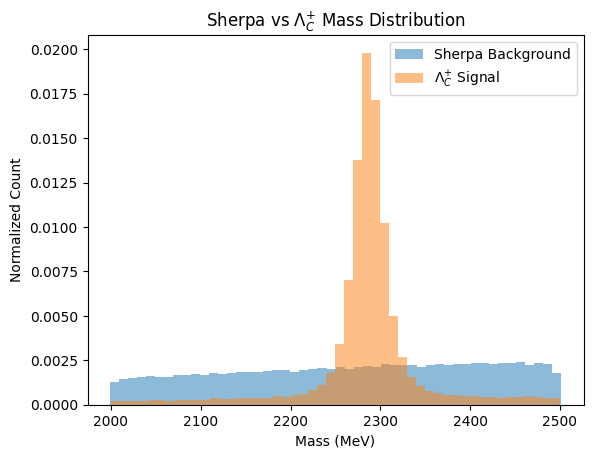

In [146]:
counts, bins, _ = plt.hist(passed_Background_both["DMesons_m"], bins=50)
counts2, bins2, _ = plt.hist(passed_Signal_both["DMesons_m"], bins=50)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

    # Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs $\Lambda_C^{+}$ Mass Distribution")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

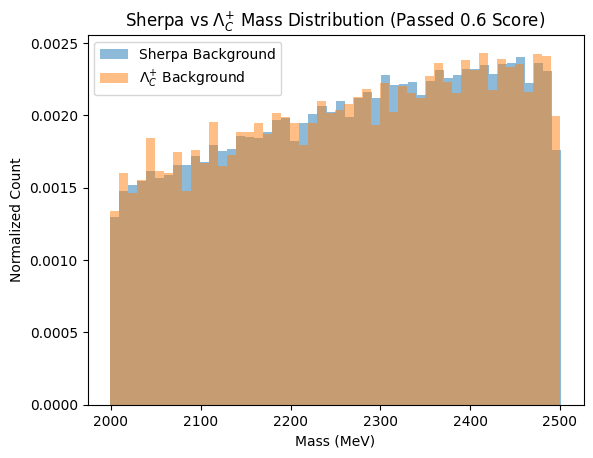

In [169]:
counts, bins, _ = plt.hist(passed_Background_both["DMesons_m"], bins=50)
counts2, bins2, _ = plt.hist(passed_Background_both1["DMesons_m"], bins=50)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Background")
plt.title("Sherpa vs $\Lambda_C^{+}$ Mass Distribution (Passed 0.6 Score)")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

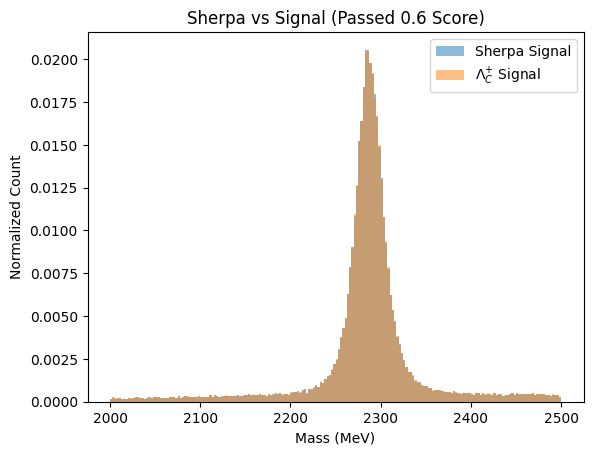

In [168]:
counts, bins, _ = plt.hist(passed_Signal_both["DMesons_m"], bins=200)
counts2, bins2, _ = plt.hist(passed_Signal_both1["DMesons_m"], bins=200)
# Normalize the histogram using the formula
density = counts / (sum(counts) * np.diff(bins))
density2 = counts2 / (sum(counts2) * np.diff(bins2))

# Plot the normalized histogram
plt.clf()
plt.bar(bins[:-1], density, width=np.diff(bins), align='edge', alpha=0.5, label = "Sherpa Background")
plt.bar(bins2[:-1], density2, width=np.diff(bins2), align='edge', alpha=0.5, label = "$\Lambda_C^{+}$ Signal")
plt.title("Sherpa vs Signal (Passed 0.6 Score)")
plt.ylabel("Normalized Count")
plt.xlabel("Mass (MeV)")
plt.legend()
plt.show()

In [128]:
#predict accuract given y_test and predictions from model
def pred_accuracy(y_test, predictions):
    D_count, Lambda_count = 0, 0

    predictions_list = []
    for pred in predictions:
        #arbitrary cutoff of 0.5
        if float(pred) > 0.5:
            predictions_list.append(int(1))
            Lambda_count+=1
        elif float(pred) < 0.5:
            predictions_list.append(int(0))
            D_count+=1
            
    accuracy = np.mean(predictions_list == y_test)
    return accuracy

accuracy_both = pred_accuracy(y_test, list(predictions_both2))
accuracy_background = pred_accuracy(y_test1, list(predictions_background2))
accuracy_signal = pred_accuracy(y_test2, list(predictions_signal2))

print("Accuracy for Both: {:.2%}".format(accuracy_both))
print("Accuracy for Only Background: {:.2%}".format(accuracy_background))
print("Accuracy for Only Signal: {:.2%}".format(accuracy_signal))

Accuracy for Both: 85.24%
Accuracy for Only Background: 75.47%
Accuracy for Only Signal: 94.84%


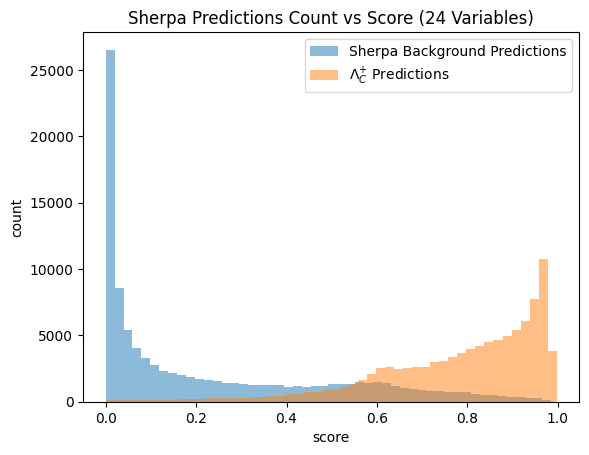

In [45]:
hist = plt.hist(predictions_background2, bins = 50, label = "Sherpa Background Predictions", alpha=0.5)
hist2 = plt.hist(predictions_signal2, bins = 50, label = "$\Lambda_C^{+}$ Predictions", alpha=0.5)
plt.xlabel("score")
plt.ylabel("count")
plt.title("Sherpa Predictions Count vs Score ({} Variables)".format(len(training_columns)))
plt.legend()
plt.show()

In [448]:
#bulk
y_true = list(y_test)
y_pred = predictions_both

In [496]:
#daughter
y_true1 = list(y_test)
y_pred1 = predictions_both1

In [497]:
#daughter + dalitz
y_true2 = list(y_test)
y_pred2 = predictions_both2

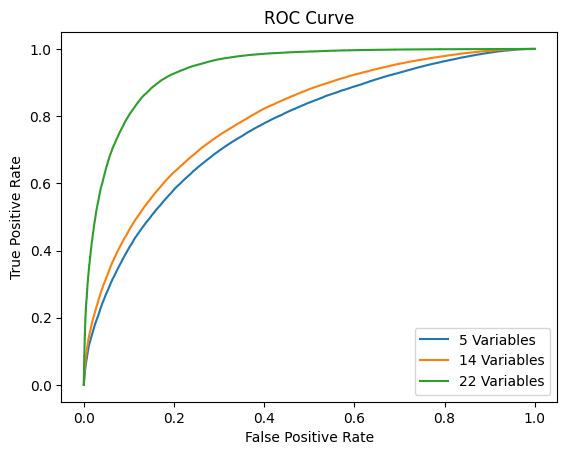

In [499]:
# Calculate TPR and FPR for different threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
fpr1, tpr1, thresholds1 = roc_curve(y_true1, y_pred1) 
fpr2, tpr2, thresholds2 = roc_curve(y_true2, y_pred2) 

# Plot ROC curve
plt.plot(fpr, tpr, label = "5 Variables")
plt.plot(fpr1, tpr1, label = "14 Variables")
plt.plot(fpr2, tpr2, label = "22 Variables")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC Curve')
plt.show()